# Toy 4: Exponential Function


In [42]:
import torch
from kan import create_dataset
from kan.custom_multkan_ddp import MultKAN
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

f = lambda x: torch.exp(-2 * x[:, [0]]) + x[:, [1]]
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=100, device=device, normalize_label=True)

| train_loss: 1.42e-02 | test_loss: 1.53e-02 | reg: 2.35e+00 | : 100%|█| 20/20 [00:01<00:00, 15.65it
| train_loss: 8.50e-07 | test_loss: 9.81e-07 | reg: 4.65e+00 | : 100%|█| 50/50 [00:01<00:00, 25.47it


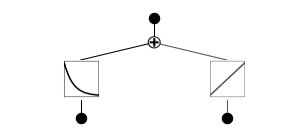

In [43]:
# grids_to_sym = [3, 5, 10, 20]
grids_to_sym = [30]

train_rmse_sym = []
test_rmse_sym = []

model = MultKAN(width=[2,1], grid=3, k=3, seed=0, device=device)
model.fit(dataset, opt='LBFGS', steps=20,
          lamb=0.01, lamb_entropy=0.1, lamb_coef=0.1, lamb_coefdiff=0.5)
model = model.prune(edge_th=0.03, node_th=0.01)

for i in range(len(grids_to_sym)):
    model = model.refine(grids_to_sym[i])
    results = model.fit(dataset, opt='LBFGS', steps=50, stop_grid_update_step=20)
    train_rmse_sym.append(results['train_loss'][-1].item())
    test_rmse_sym.append(results['test_loss'][-1].item())

model.plot()

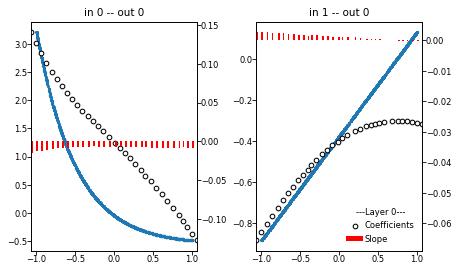

[<Figure size 450x262.5 with 4 Axes>]

In [44]:
from kan.custom_processing import plot_activation_and_spline_coefficients

plot_activation_and_spline_coefficients(model, x=dataset)

r2 is 1.0000003576278687
fixing (0,0,0) with exp, r2=1.0, c=2
r2 is 1.0000003576278687
fixing (0,1,0) with x, r2=1.0, c=1


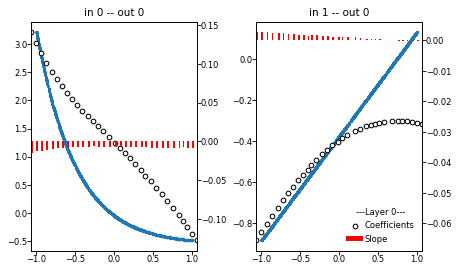

[<Figure size 450x262.5 with 4 Axes>]

In [45]:
model.auto_symbolic()
plot_activation_and_spline_coefficients(model, x=dataset)

In [46]:
from kan.utils import ex_round
model.fit(dataset)
ex_round(model.symbolic_formula()[0][0], 4)

| train_loss: 1.36e-07 | test_loss: 1.32e-07 | reg: 0.00e+00 | : 100%|█| 100/100 [00:02<00:00, 39.14


0.5095*x_2 - 0.929 + 0.5095*exp(-2.0*x_1)

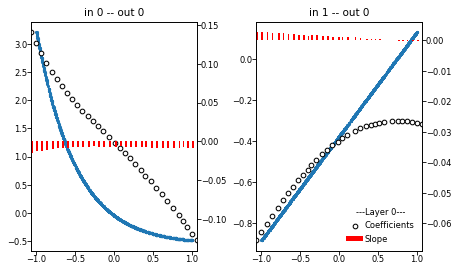

[<Figure size 450x262.5 with 4 Axes>]

In [47]:
plot_activation_and_spline_coefficients(model, x=dataset)

In [48]:
depth = len(model.act_fun)
layers_to_plot = list(range(depth))

coef_model = []
grid_model = []
for l in layers_to_plot:
    act = model.act_fun[l]
    ni, no = act.coef.shape[:2]
    coef = act.coef.tolist()
    coef_model.append(coef_model)
    print(f"Layer {l}: {ni}x{no}")
    print(coef)
    grid_layer = model.act_fun[l].grid
    grid_model.append(grid_layer)
    print(grid_layer)

Layer 0: 2x1
[[[0.14130738377571106, 0.12683145701885223, 0.11379094421863556, 0.10139905661344528, 0.09022070467472076, 0.08017511665821075, 0.07129058241844177, 0.06292061507701874, 0.05477478727698326, 0.04720081388950348, 0.03978940099477768, 0.03294653818011284, 0.026078026741743088, 0.019687797874212265, 0.012907765805721283, 0.005621097516268492, -0.0018936865963041782, -0.008817115798592567, -0.015174755826592445, -0.02185407653450966, -0.029420608654618263, -0.036495186388492584, -0.04405629262328148, -0.05130540952086449, -0.05994047224521637, -0.06818146258592606, -0.07729446142911911, -0.08611387014389038, -0.09473954886198044, -0.10278703272342682, -0.11051260679960251, -0.11903160065412521, -0.12783339619636536]], [[-0.06563159823417664, -0.06289355456829071, -0.06028231605887413, -0.05751128867268562, -0.05494280904531479, -0.052452683448791504, -0.05015089362859726, -0.04798382520675659, -0.04588893800973892, -0.044032443314790726, -0.042369142174720764, -0.040777262300

Text(0, 0.5, 'Attribution score')

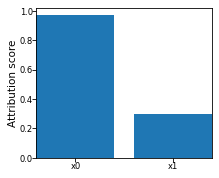

In [49]:
fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

[tensor(251), tensor(241), tensor(256), tensor(252)]


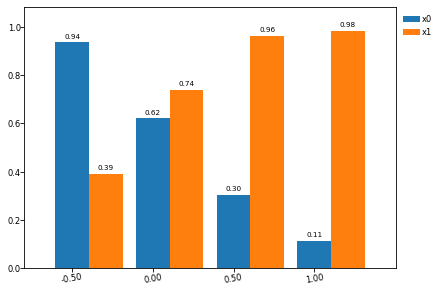

In [50]:
mask_idx = 0
mask_interval = [-1, -0.5, 0., 0.5, 1]
# mask_interval = [-1, 0.5, 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'{ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        model.forward(x_tensor_masked)
        scores_interval.append(model.feature_score.detach().cpu().numpy())
    else:
        scores_interval.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

한 번 spline coefficients의 기울기 방향이 변하는 x1의 영역에 대해서 attribution score를 추적하자.

[tensor(757), tensor(243)]


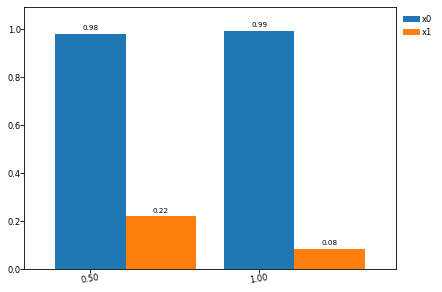

In [51]:
mask_idx = 1
# mask_interval = [-1, -0.5, 0., 0.5, 1]
mask_interval = [-1, 0.5, 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'{ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
scores_interval_norm = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        x_std = torch.std(x_tensor_masked, dim=0).detach().cpu().numpy()
        model.forward(x_tensor_masked)

        score_masked = model.feature_score.detach().cpu().numpy()
        score_norm = score_masked / x_std
        scores_interval.append(score_masked)
        scores_interval_norm.append(score_norm)
    else:
        scores_interval.append(np.zeros(scores_tot.shape))
        scores_interval_norm.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

Attribution score가 input data의 분포에 영향을 받기 때문에 input의 std로 나눠서 비교하기 -- x1의 영역에 대해서는 attribution score의 역전이 일어나지 않음.

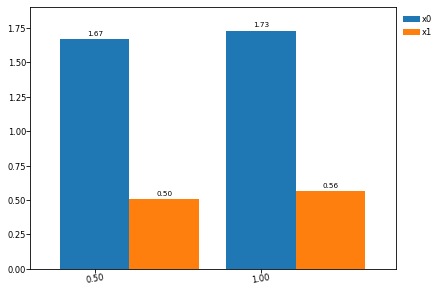

In [52]:
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval_norm])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval_norm], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

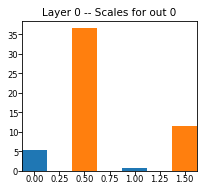

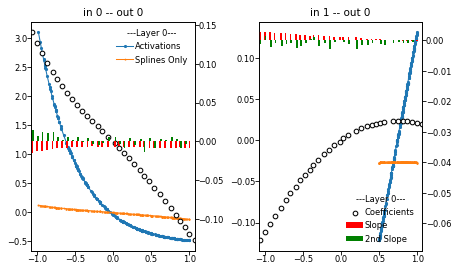

In [53]:
depth = len(model.act_fun)
layers_to_plot = list(range(depth))

for l in layers_to_plot:
    act = model.act_fun[l]
    ni, no = act.coef.shape[:2]
    coef = act.coef.tolist()
    for j in range(no):
        scale_base = act.scale_base[:,j].cpu().detach().numpy()
        scale_spline = act.scale_sp[:,j].cpu().detach().numpy()

        _, ax_scales = plt.subplots(1,1)
        ax_scales.bar([i for i in range(len(scale_base))], scale_base, label='base', width=0.25)
        ax_scales.bar([i + 0.5 for i in range(len(scale_spline))], scale_spline, label='spline', width=0.25)
        ax_scales.set_title(f'Layer {l} -- Scales for out {j}', fontsize=10)

    # Dynamic figure size and constrained layout to avoid overlaps
    fig, axs = plt.subplots(nrows=no, ncols=ni, squeeze=False,
                            figsize=(max(2.5*ni, 6), max(2.5*no, 3.5)),
                            constrained_layout=True)
    second_axs = np.zeros_like(axs)
    for i in range(ni):
        for j in range(no):
            ax = axs[j, i]
            # Gather pre- and post-activations and sort by input
            inputs = model.spline_preacts[l][:, j, i].cpu().detach().numpy()
            outputs = model.spline_postacts[l][:, j, i].cpu().detach().numpy()
            output_spline = model.spline_postsplines[l][:, j, i].cpu().detach().numpy() # without base function values
            coef_node = coef[i][j]
            num_knot = act.grid.shape[1]
            spline_radius = int((num_knot - len(coef_node)) / 2)
            bar_width = min(act.grid[i, 1:] - act.grid[i, :-1]) / 2

            rank = np.argsort(inputs)
            ax.plot(inputs[rank], outputs[rank], marker='o', ms=2, lw=1, label='Activations')
            ax.plot(inputs[rank], output_spline[rank], marker='^', ms=1, lw=1, label='Splines Only')

            ax2 = ax.twinx()
            second_axs[j, i] = ax2
            ax2.scatter(act.grid[i, spline_radius:-spline_radius], coef_node,
                       s=20, color='white', edgecolor='k', label='Coefficients')
            slope = [x - y for x, y in zip(coef_node[1:], coef_node[:-1])]
            slope_2nd = [(x - y)*10 for x, y in zip(slope[1:], slope[:-1])]
            bars = ax2.bar(act.grid[i, spline_radius:-(spline_radius + 1)], slope,
                    width=bar_width, align='center', color='r', label='Slope')
            bars_2nd = ax2.bar(act.grid[i, spline_radius:-(spline_radius + 2)], slope_2nd,
                    width=bar_width, align='edge', color='g', label='2nd Slope')
            # ax2.bar_label(bars, fmt='%.2f', fontsize=6, padding=3)
            ax.set_title(f'in {i} -- out {j}', fontsize=10)
    axs[0, 0].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    second_axs[-1, -1].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)

    plt.show()

[tensor(353), tensor(647)]


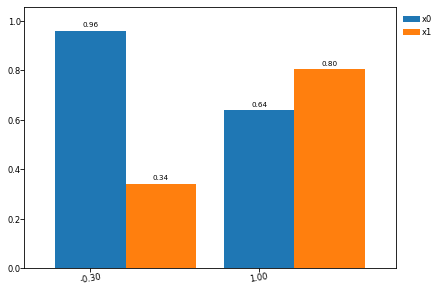

In [54]:
mask_idx = 0
mask_interval = [-1, -0.3, 1]
# mask_interval = [-1, 0.5, 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'{ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        model.forward(x_tensor_masked)
        scores_interval.append(model.feature_score.detach().cpu().numpy())
    else:
        scores_interval.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

Layer 갯수에 따라서 Coefficients의 의미가 달라진다.